<h1 style="text-align:center; color:white; background:#FFB600; padding: 10px"> Deep Learning to predict Alzhimer from MRI Images </h1>

<p style="text-align:center; border: solid black thin"><a href="https://github.com/basit188/alzhimer">https://github.com/basit188/alzhimer</a></p>



![workflow](images/work_flow.png)

# Data Loading

In [141]:
IMG_SZ = 128
EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 32

In [293]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()


print("----------original  train and validation set -------------")
trainset = gen.flow_from_directory("dataset/train/", batch_size=BATCH_SIZE, target_size=(IMG_SZ, IMG_SZ), 
    class_mode='categorical', color_mode='rgb')
valset = gen.flow_from_directory( "dataset/val/", batch_size=BATCH_SIZE, target_size=(IMG_SZ, IMG_SZ),
    class_mode='categorical', color_mode='rgb')


print("----------augmented  train and validation set -------------")
aug_trainset = gen.flow_from_directory("augmented_dataset/train/", batch_size=BATCH_SIZE, target_size=(IMG_SZ, IMG_SZ), 
    class_mode='categorical', color_mode='rgb')
aug_valset = gen.flow_from_directory( "augmented_dataset/val/", batch_size=BATCH_SIZE, target_size=(IMG_SZ, IMG_SZ),
    class_mode='categorical', color_mode='rgb')


print("----------test set-------------")
testset = gen.flow_from_directory("dataset/test",target_size=(IMG_SZ,IMG_SZ),
    class_mode='categorical', batch_size=1,shuffle=False)
label_names = list(testset.class_indices.keys())
label_names

----------original  train and validation set -------------
Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
----------augmented  train and validation set -------------
Found 5505 images belonging to 4 classes.
Found 1176 images belonging to 4 classes.
----------test set-------------
Found 962 images belonging to 4 classes.


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [288]:
import cv2
from glob import glob

def plot_images(image_paths,title):
    image_paths = image_paths[:5]
    fig = plt.figure(figsize=(15,4))
    fig.suptitle(title,fontsize="x-large",fontweight="bold")
    for i,image_path in enumerate(image_paths):
        ax = plt.subplot(1,len(image_paths),i+1)
        ax.imshow(cv2.imread(image_path))
        ax.set_xticks([])
        ax.set_yticks([])

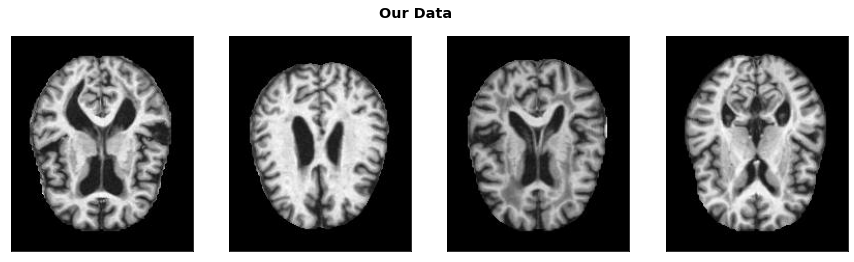

In [290]:
import os
selected_files = []
for disease in label_names:
    selected_files.append(glob(f"dataset/train/{disease}/*")[0])
plot_images(selected_files,"Our Data")

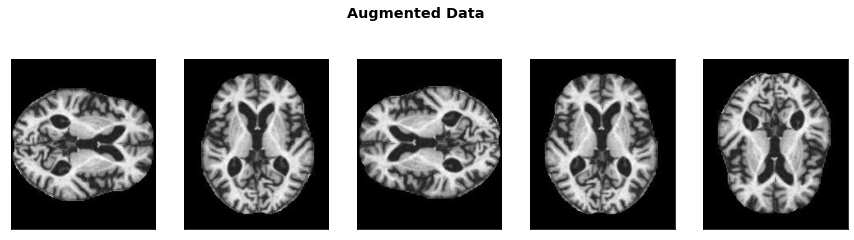

In [291]:
files = glob("augmented_dataset/train/ModerateDemented/moderateDem14*")[:5]
plot_images(files,"Augmented Data")

Text(0.5, 1.0, 'After Augmentation')

<Figure size 432x288 with 0 Axes>

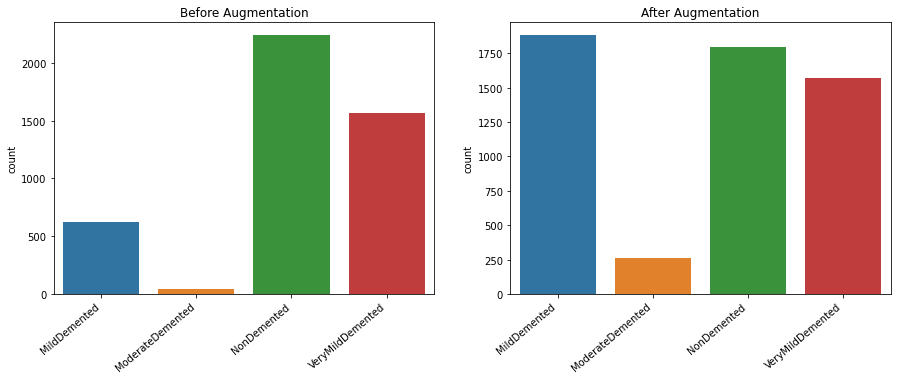

In [292]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.despine()

fig,axes = plt.subplots(1,2,figsize=(15,5))

plot_trainset = [label_names[l] for l in trainset.labels]
plot_aug_trainset = [label_names[l] for l in aug_trainset.labels]


ax = sns.countplot(x=plot_trainset,ax=axes[0])
ax.set_xticklabels(label_names, rotation=40, ha="right")
ax.set_title("Before Augmentation")

ax = sns.countplot(x=plot_aug_trainset,ax=axes[1])
ax.set_xticklabels(label_names, rotation=40, ha="right")
ax.set_title("After Augmentation")


# MODEL DESIGN

In [308]:
# develop model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization,ReLU, DepthwiseConv2D, Conv2D, ZeroPadding2D
from tensorflow.keras.applications import MobileNet, ResNet101, ResNet50
from tensorflow.keras.optimizers import Adam

def get_model():
    base_model=MobileNet(weights='imagenet',pooling="avg",include_top=False,input_shape = (IMG_SZ, IMG_SZ,3)) #imports the mobilenet model and discards the last 1000 neuron layer.
    x=base_model.output
    # x=GlobalAveragePooling2D()(x)
    x=Dense(224,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dense(128,activation='relu')(x) #dense layer 2
    x=Dense(64,activation='relu')(x) #dense layer 3
    preds=Dense(4,activation='softmax')(x) #final layer with softmax activation
    model = Model(inputs=base_model.input,outputs=preds)
    model._name="MobileNet_based_model"
    
    Adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, 
                                        beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

    model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = get_model()
model._name="MobileNet"


aug_model = get_model()
aug_model._name="Aug_MobileNet_based_model"

![model](images/model.png)

In [309]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10)
check_point = ModelCheckpoint(filepath=f"model_checkpoints/best_weights_{model.name}.h5",save_weights_only=True,
                    monitor='val_accuracy',mode='max',save_best_only=True)

aug_check_point = ModelCheckpoint(filepath=f"model_checkpoints/best_weights_{aug_model.name}.h5",save_weights_only=True,
                    monitor='val_accuracy',mode='max',save_best_only=True)

In [ ]:
history = model.fit(trainset, validation_data=valset,verbose=1,steps_per_epoch=50,
                   epochs=EPOCHS, callbacks=[early_stop,check_point])
aug_history = aug_model.fit(aug_trainset, validation_data=aug_valset,verbose=1,steps_per_epoch=50,
                   epochs=EPOCHS, callbacks=[early_stop,aug_check_point])
np.save("model_checkpoints/history.npy",history.history)
np.save("model_checkpoints/aug_history.npy",aug_history.history)

Epoch 1/100
50/50 [==============================] - 5s 77ms/step - loss: 1.0247 - accuracy: 0.5362 - val_loss: 0.9716 - val_accuracy: 0.5422
Epoch 2/100
50/50 [==============================] - 3s 58ms/step - loss: 0.7022 - accuracy: 0.7163 - val_loss: 0.9057 - val_accuracy: 0.5965
Epoch 3/100
50/50 [==============================] - 3s 58ms/step - loss: 0.5317 - accuracy: 0.8130 - val_loss: 0.7750 - val_accuracy: 0.6809
Epoch 4/100
50/50 [==============================] - 3s 53ms/step - loss: 0.3852 - accuracy: 0.8637 - val_loss: 0.7201 - val_accuracy: 0.6580
Epoch 5/100
50/50 [==============================] - 3s 58ms/step - loss: 0.2598 - accuracy: 0.9144 - val_loss: 0.6426 - val_accuracy: 0.7310
Epoch 6/100
50/50 [==============================] - 3s 58ms/step - loss: 0.1684 - accuracy: 0.9487 - val_loss: 0.3505 - val_accuracy: 0.8686
Epoch 7/100
50/50 [==============================] - 3s 58ms/step - loss: 0.1052 - accuracy: 0.9731 - val_loss: 0.3104 - val_accuracy: 0.8916
Epoch 

# MODEL EVALUATION

In [ ]:
def plot_history_curves(history):
    fig,axes = plt.subplots(1,2,figsize=(15,5))
    sns.despine()
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    axes[0].plot(epochs, loss, 'b--', label='Training loss')
    axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
    axes[0].set_title('Training and validation loss')
    axes[0].legend()
    axes[1].plot(epochs, acc, 'b--', label='Training acc')
    axes[1].plot(epochs, val_acc, 'r', label='Validation acc')
    axes[1].set_title('Training and validation accuracy')
    axes[1].legend()


In [ ]:
history = np.load("model_checkpoints/history.npy",allow_pickle=True).item()
plot_history_curves(history)

In [ ]:
aug_history = np.load("model_checkpoints/aug_history.npy",allow_pickle=True).item()
plot_history_curves(aug_history)

In [304]:
model.load_weights(f"model_checkpoints/best_weights_{model.name}.h5")
aug_model.load_weights(f"model_checkpoints/best_weights_{aug_model.name}.h5")

print("Model Accuracy: ")
eval = model.evaluate(testset)


print("Model Accuracy for Augmented Data: ")
aug_eval = aug_model.evaluate(testset)

Model Accuracy: 
962/962 [==============================] - 7s 7ms/step - loss: 0.3742 - accuracy: 0.8711
Model Accuracy for Augmented Data: 
962/962 [==============================] - 7s 7ms/step - loss: 0.1695 - accuracy: 0.9407


962/962 [==============================] - 6s 6ms/step


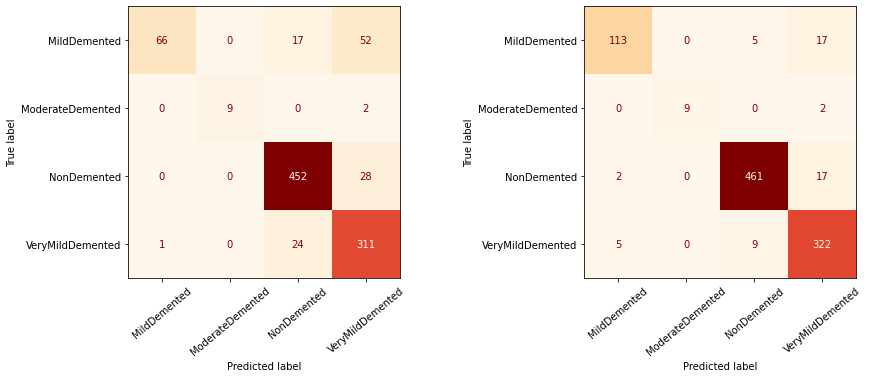

In [305]:
from sklearn import metrics


predictions = model.predict(testset, verbose=1)
predicted = np.argmax(predictions, axis=1) # Get the index of the class with the highest probability score


predictions = aug_model.predict(testset, verbose=1)
aug_predicted = np.argmax(predictions, axis=1) # Get the index of the class with the highest probability score

actual = testset.labels

confusion_matrix = metrics.confusion_matrix(actual, predicted)
aug_confusion_matrix= metrics.confusion_matrix(actual, aug_predicted)

fig,axes = plt.subplots(1,2,figsize=(15,5))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=label_names)
cm_display.plot(colorbar=False,ax=axes[0],xticks_rotation=40,cmap="OrRd")

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = aug_confusion_matrix,display_labels=label_names)
cm_display.plot(colorbar=False,ax=axes[1],xticks_rotation=40,cmap="OrRd")


In [306]:
report = metrics.classification_report(actual, predicted,target_names=label_names)
print("=============== CLASSIFICATION RERPORT===============")
print(report)

report = metrics.classification_report(actual, aug_predicted,target_names=label_names)
print("=============== CLASSIFICATION RERPORT FOR AUGMENTED IMAGES===============")
print(report)

=============== CLASSIFICATION RERPORT===============
                  precision    recall  f1-score   support

    MildDemented       0.99      0.49      0.65       135
ModerateDemented       1.00      0.82      0.90        11
     NonDemented       0.92      0.94      0.93       480
VeryMildDemented       0.79      0.93      0.85       336

        accuracy                           0.87       962
       macro avg       0.92      0.79      0.83       962
    weighted avg       0.88      0.87      0.86       962

=============== CLASSIFICATION RERPORT FOR AUGMENTED IMAGES===============
                  precision    recall  f1-score   support

    MildDemented       0.94      0.84      0.89       135
ModerateDemented       1.00      0.82      0.90        11
     NonDemented       0.97      0.96      0.97       480
VeryMildDemented       0.90      0.96      0.93       336

        accuracy                           0.94       962
       macro avg       0.95      0.89      0.92       